In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from itertools import combinations
from pytorchtools import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping

Using backend: pytorch


In [2]:
LABELS = 3
MAX_LENGTH =  38
PIXEL = 49
BATCH_SIZE = 32
EMBED_SIZE = 300
DEVICE = 'cuda:0'
WINDOWS = 2
NB_EPOCH = 100
glove_file = '/root/liaowenxiong/pyworkspace/multi_analysis/dataset/glove/tmp_glove.6B.300d.txt'
tokenizer = BertWordPieceTokenizer("/root/liaowenxiong/pyworkspace/dataset/bert-base-uncased-vocab.txt", lowercase=True)


## build graph

In [3]:

def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,pixel):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)
    
        # text with pixel
        for j in range(max_len,max_len + pixel):
            for i in range(0,max_len):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    


batch_graph = get_batch_graph(BATCH_SIZE, MAX_LENGTH, WINDOWS)
batch_fusion_graph = get_fusion_batch(BATCH_SIZE, MAX_LENGTH, PIXEL)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


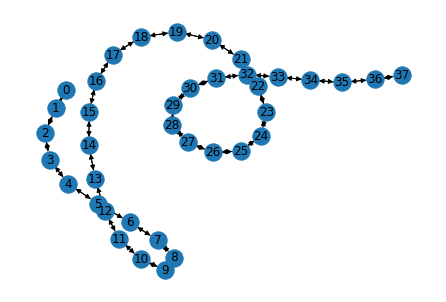

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


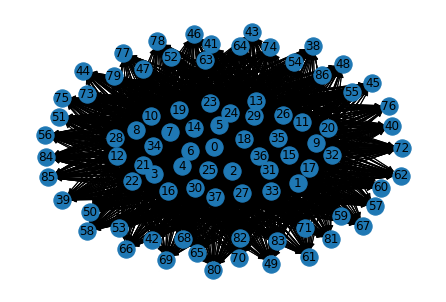

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


In [6]:
def load_data():
    
    images = torch.load('./dataset/twitter26k/images.pkl')
    texts = torch.load('./dataset/twitter26k/text.pkl')
    texts = [text.strip().lower().replace('#',' # ') for text in texts]
    y = torch.load('./dataset/twitter26k/y.pkl')
    
    return texts,images,y


def get_idx2word(texts):
    cutoff = 1
    word_to_idx = {}
    word_to_idx['<unk>'] = 0
    word_freq = {}
    for text in texts:
        for t in text:
            if t in word_freq:
                word_freq[t] = word_freq[t] + 1
            else:
                word_freq[t] = 1

    for word, freq in word_freq.items():
        if freq > cutoff:
            word_to_idx[word] = len(word_to_idx) 

    idx_to_word = {i: word for  (word,i) in word_to_idx.items()}
    
    return word_to_idx,idx_to_word

def get_token(text,word_to_idx,max_length,pad=0):
    idx = []
    text = text[0:max_length]
    for t in text:
        if t in word_to_idx:
            idx.append(word_to_idx[t])
        else:
            idx.append(pad)
    idx = idx if len(idx) == max_length else np.concatenate((idx,np.zeros(max_length-len(idx))))
    
    return idx

def get_token_text(texts):
    x_texts = []
    for t in texts:
        x_texts.append(get_token(t,word_to_idx,max_length = MAX_LENGTH,pad=0))
    x_texts = np.array(x_texts)
    
    return x_texts


def load_glove_weight(glove_file,idx_to_word,embed_size):
    # # #加载词向量
    
    wvmodel = KeyedVectors.load_word2vec_format(glove_file, binary=False,encoding='utf8')
    wvmodel.init_sims(replace=True)  

    weight = torch.zeros(len(idx_to_word), embed_size)

    for i in range(len(wvmodel.index2word)):
        try:
            index = word_to_idx[wvmodel.index2word[i]]
        except:
            continue

        weight[index, :] = torch.from_numpy(wvmodel.get_vector(
                idx_to_word[word_to_idx[wvmodel.index2word[i]]]))
    return weight

def get_data_loader(shuffle_index,fold_index,fold_N = 10):
    fold_sample_num = len(shuffle_index)//fold_N
    test_index = shuffle_index[fold_sample_num * fold_index : fold_sample_num * (fold_index+1)]
    train_val_index = np.concatenate((shuffle_index[0:fold_sample_num * fold_index],shuffle_index[fold_sample_num * (fold_index+1):])).astype(int)
    train_index = train_val_index[0: -fold_sample_num]
    val_index = train_val_index[-fold_sample_num:]
    
    print('test_index:{begin}==>{end}'.format(begin = fold_sample_num * fold_index,end =  fold_sample_num * (fold_index+1)))

    train_texts = x_texts[train_index]
    train_images = images[train_index]
    train_y = y[train_index]
    
    val_texts = x_texts[val_index]
    val_images = images[val_index]
    val_y = y[val_index]
    
    test_texts = x_texts[test_index]
    test_images = images[test_index]
    test_y = y[test_index]

    train_set = data.TensorDataset(torch.LongTensor(train_texts),torch.FloatTensor(train_images) ,torch.LongTensor(train_y))
    val_set = data.TensorDataset(torch.LongTensor(val_texts),torch.FloatTensor(val_images), torch.LongTensor(val_y))
    test_set = data.TensorDataset(torch.LongTensor(test_texts),torch.FloatTensor(test_images), torch.LongTensor(test_y))

    train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                             shuffle=True)
    val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    test_data_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    
    return train_data_loader,val_data_loader,test_data_loader



texts,images,y = load_data()
texts = [tokenizer.encode(t).tokens[1:-1] for t  in texts]
word_to_idx,idx_to_word = get_idx2word(texts)
x_texts = get_token_text(texts)
glove_weight = load_glove_weight(glove_file,idx_to_word,EMBED_SIZE)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


In [7]:
class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
       
        h = self.linear(node.data['h'])
        h = self.activation(h)
        
        return {'h1' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)
        self.msg = fn.copy_src(src='h', out='m')
    
    def reduce(self,nodes):
        """Take an average over all neighbor node features hu and use it to
        overwrite the original node feature."""
        accum = torch.mean(nodes.mailbox['m'], 1)
        h = nodes.data['h']
        accum = 0.8 * accum + 0.2 * h

        return {'h': accum}

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature

        g.update_all(self.msg, self.reduce)
        g.apply_nodes(func=self.apply_mod)
      
        return g.ndata.pop('h1')


class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
#         # equation (4)
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):

        # equation (1)
        h = self.fc(h)
        bg.ndata['h'] = h
        # equation (2)
        bg.apply_edges(self.edge_attention)
        # equation (3) & (4)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
#         print('weight',weights)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, embed_size, labels,max_length,pixel,drop_rate = 0.4,glove_weight=None):
        super(Classifier, self).__init__()
        self.labels = labels
        self.embedding = nn.Embedding.from_pretrained(glove_weight,freeze= False)
        self.dropout = nn.Dropout(drop_rate)
        self.text_normal = nn.LayerNorm((max_length,embed_size))
        self.image_normal = nn.LayerNorm((pixel,embed_size))
        self.embed_size = embed_size
        self.GCN = GCN(embed_size, self.embed_size, F.relu)
        self.GCN2 = GCN(self.embed_size, self.embed_size, F.relu)
        self.GAT = GAT(self.embed_size, self.embed_size, F.relu)
        self.att = SelfAttention(self.embed_size )
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.embed_size)

        self.classify_h = nn.Linear(self.embed_size  , self.embed_size)
        self.classify = nn.Linear(self.embed_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)
        
        text = self.embedding(text)
        text = torch.reshape(text,(-1,self.embed_size))   #[-1,hidden_size]
        text = self.GCN(bg, text)
        text = torch.reshape(text,(bs,-1,self.embed_size))   #[bs,max_len,hidden_size]
        text = self.text_normal(text)
        with torch.no_grad():
            img = self.image_model.extract_features(image) #[bs,1280,7,7]  1536
#         img =  F.tanh(img)
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.embed_size))   #[bs,49,hidden_size]
#         img = self.image_normal(img)

        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)

        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)

#         feature = torch.cat([feature_short, gat_feature,head_feature], 1)
#         feature = torch.reshape(feature,(bs,-1))
        feature = self.dropout(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)

    
def model_test(data_loader,model,report = False):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []
    loss_l = []
    loss_func = nn.CrossEntropyLoss()
    for step,(b_texts,b_image_features, test_y_batch) in enumerate(data_loader):

        
        b_texts = b_texts.to(torch.device(DEVICE))
        b_image_features = b_image_features.to(torch.device(DEVICE))
        test_y_batch = test_y_batch.to(torch.device(DEVICE))
        
        test_net_out = model(b_texts,b_image_features)
        loss = loss_func(test_net_out, test_y_batch) 
        loss_l.append(loss.cpu().data.numpy())
        
        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch.cpu().data.numpy()), axis=0)
    
    if report:
        print(classification_report(test_Y,pred_Y,digits = 5))
    f1_macro = f1_score(test_Y,pred_Y,average='macro')
    f1_weighted = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    loss_mean = np.mean(np.array(loss_l))
    
    return f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean


def draw_cofusion_matrix(test_Y,pred_Y, labels=[0, 1, 2]):
    sns.set()
    
    plt.figure(figsize=(300, 300))
    f,ax=plt.subplots()
    C2= confusion_matrix(test_Y,pred_Y, labels=[0, 1, 2],normalize = 'true')
    print(C2) #打印出来看看
    sns.heatmap(C2,annot=True,ax=ax,cmap="YlGnBu") #画热力图

    labels = ['negative','neutral','positive']
    ax.set_title('confusion matrix') #标题
    ax.set_xticklabels( labels) 
    ax.set_yticklabels(labels) 
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    plt.show()

test_index:0==>2695
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.68
epoch:0, step:200, loss:0.39
epoch:0, step:300, loss:0.35
epoch:0, step:400, loss:0.33
epoch:0, step:500, loss:0.16
epoch:0, step:600, loss:0.42
*** 0.8974287985166519 0.9148411091807633 0.9150278293135437
0.9062283139150977, best: 0.9062283139150977
epoch:1, step:0, loss:0.21
epoch:1, step:100, loss:0.22
epoch:1, step:200, loss:0.38
epoch:1, step:300, loss:0.51
epoch:1, step:400, loss:0.10
epoch:1, step:500, loss:0.21
epoch:1, step:600, loss:0.13
*** 0.9079386638932117 0.9214032420791802 0.9209647495361781
0.9144517067146949, best: 0.9144517067146949
epoch:2, step:0, loss:0.06
epoch:2, step:100, loss:0.06
epoch:2, step:200, loss:0.06
epoch:2, step:300, loss:0.02
epoch:2, step:400, loss:0.07
epoch:2, step:500, loss:0.04
epoch:2, step:600, loss:0.01
*** 0.9152528552037843 0.9303828111005822 0.9302411873840445
0.9227470212939144, best: 0.9227470212939144
EarlyStopping

<Figure size 21600x21600 with 0 Axes>

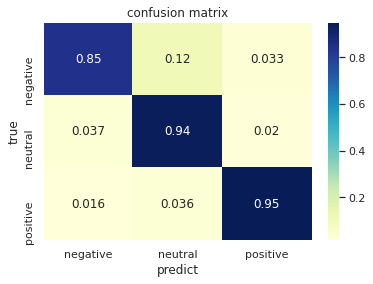

test_index:2695==>5390
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.14
epoch:0, step:100, loss:0.87
epoch:0, step:200, loss:0.57
epoch:0, step:300, loss:0.26
epoch:0, step:400, loss:0.48
epoch:0, step:500, loss:0.41
epoch:0, step:600, loss:0.26
*** 0.8868564881710578 0.9067641223970286 0.9072356215213359
0.8970460548461968, best: 0.8970460548461968
epoch:1, step:0, loss:0.13
epoch:1, step:100, loss:0.26
epoch:1, step:200, loss:0.24
epoch:1, step:300, loss:0.12
epoch:1, step:400, loss:0.18
epoch:1, step:500, loss:0.23
epoch:1, step:600, loss:0.06
*** 0.9234304399261327 0.9364740361674782 0.9369202226345084
0.9301753312803205, best: 0.9301753312803205
epoch:2, step:0, loss:0.06
epoch:2, step:100, loss:0.11
epoch:2, step:200, loss:0.06
epoch:2, step:300, loss:0.12
epoch:2, step:400, loss:0.01
epoch:2, step:500, loss:0.02
epoch:2, step:600, loss:0.11
*** 0.9180084089632818 0.9347188455914744 0.935064935064935
0.9265366720141084, best: 0.9301753312803205
EarlyStoppi

<Figure size 21600x21600 with 0 Axes>

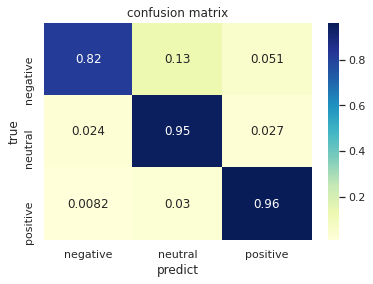

test_index:5390==>8085
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.11
epoch:0, step:100, loss:0.94
epoch:0, step:200, loss:0.50
epoch:0, step:300, loss:0.29
epoch:0, step:400, loss:0.33
epoch:0, step:500, loss:0.24
epoch:0, step:600, loss:0.27
*** 0.8902577181694848 0.9098955283747062 0.9109461966604824
0.9006019574149836, best: 0.9006019574149836
epoch:1, step:0, loss:0.36
epoch:1, step:100, loss:0.09
epoch:1, step:200, loss:0.23
epoch:1, step:300, loss:0.23
epoch:1, step:400, loss:0.07
epoch:1, step:500, loss:0.36
epoch:1, step:600, loss:0.05
*** 0.9060079691368584 0.9228992635460802 0.922077922077922
0.9140429456073902, best: 0.9140429456073902
epoch:2, step:0, loss:0.06
epoch:2, step:100, loss:0.14
epoch:2, step:200, loss:0.02
epoch:2, step:300, loss:0.10
epoch:2, step:400, loss:0.01
epoch:2, step:500, loss:0.03
epoch:2, step:600, loss:0.10
*** 0.922349409786456 0.9356326414353543 0.9354359925788497
0.9288927011826529, best: 0.9288927011826529
epoch:3, ste

<Figure size 21600x21600 with 0 Axes>

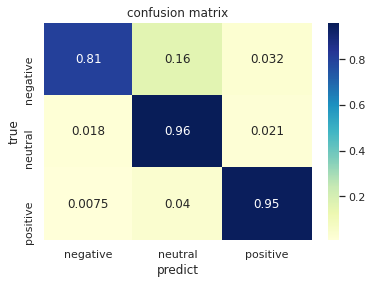

test_index:8085==>10780
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.06
epoch:0, step:100, loss:0.78
epoch:0, step:200, loss:0.50
epoch:0, step:300, loss:0.37
epoch:0, step:400, loss:0.27
epoch:0, step:500, loss:0.40
epoch:0, step:600, loss:0.28
*** 0.9002064148238516 0.917039206694787 0.9165120593692022
0.9083592370965269, best: 0.9083592370965269
epoch:1, step:0, loss:0.11
epoch:1, step:100, loss:0.14
epoch:1, step:200, loss:0.08
epoch:1, step:300, loss:0.10
epoch:1, step:400, loss:0.03
epoch:1, step:500, loss:0.29
epoch:1, step:600, loss:0.19
*** 0.9195722005971335 0.9318126014542005 0.9317254174397032
0.9256488090184183, best: 0.9256488090184183
epoch:2, step:0, loss:0.09
epoch:2, step:100, loss:0.17
epoch:2, step:200, loss:0.06
epoch:2, step:300, loss:0.18
epoch:2, step:400, loss:0.06
epoch:2, step:500, loss:0.06
epoch:2, step:600, loss:0.03
*** 0.923326829765094 0.9349724161296766 0.935064935064935
0.9291958824150145, best: 0.9291958824150145
EarlyStoppin

<Figure size 21600x21600 with 0 Axes>

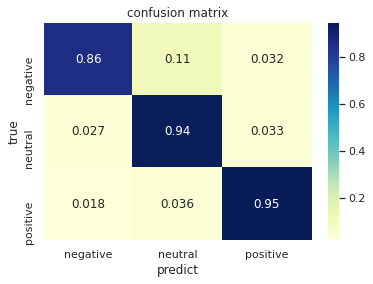

test_index:10780==>13475
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.01
epoch:0, step:100, loss:0.78
epoch:0, step:200, loss:0.56
epoch:0, step:300, loss:0.22
epoch:0, step:400, loss:0.29
epoch:0, step:500, loss:0.33
epoch:0, step:600, loss:0.22
*** 0.8933528238790435 0.9126789559077767 0.9139146567717996
0.9036337403254215, best: 0.9036337403254215
epoch:1, step:0, loss:0.17
epoch:1, step:100, loss:0.16
epoch:1, step:200, loss:0.04
epoch:1, step:300, loss:0.11
epoch:1, step:400, loss:0.14
epoch:1, step:500, loss:0.05
epoch:1, step:600, loss:0.22
*** 0.9070736887161815 0.9255336365661685 0.9269016697588126
0.9169876792374971, best: 0.9169876792374971
epoch:2, step:0, loss:0.35
epoch:2, step:100, loss:0.05
epoch:2, step:200, loss:0.19
epoch:2, step:300, loss:0.09
epoch:2, step:400, loss:0.05
epoch:2, step:500, loss:0.04
epoch:2, step:600, loss:0.31
*** 0.9172354765219288 0.9310293065149775 0.9309833024118739
0.9241093894669014, best: 0.9241093894669014
EarlySto

<Figure size 21600x21600 with 0 Axes>

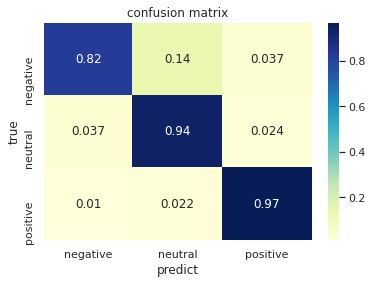

test_index:13475==>16170
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.08
epoch:0, step:100, loss:0.88
epoch:0, step:200, loss:0.54
epoch:0, step:300, loss:0.21
epoch:0, step:400, loss:0.41
epoch:0, step:500, loss:0.23
epoch:0, step:600, loss:0.26
*** 0.8959713547065542 0.9134562277205407 0.9139146567717996
0.904943005739177, best: 0.904943005739177
epoch:1, step:0, loss:0.14
epoch:1, step:100, loss:0.14
epoch:1, step:200, loss:0.18
epoch:1, step:300, loss:0.17
epoch:1, step:400, loss:0.26
epoch:1, step:500, loss:0.15
epoch:1, step:600, loss:0.31
*** 0.9162466838244384 0.9297014797007185 0.9302411873840445
0.9232439356042415, best: 0.9232439356042415
epoch:2, step:0, loss:0.23
epoch:2, step:100, loss:0.07
epoch:2, step:200, loss:0.05
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.03
epoch:2, step:500, loss:0.07
epoch:2, step:600, loss:0.06
*** 0.9166135891327133 0.9315564227282743 0.9317254174397032
0.9241695032862083, best: 0.9241695032862083
EarlyStopp

<Figure size 21600x21600 with 0 Axes>

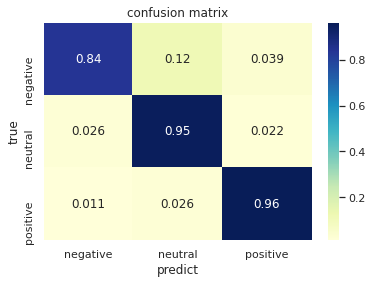

test_index:16170==>18865
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.13
epoch:0, step:100, loss:0.76
epoch:0, step:200, loss:0.41
epoch:0, step:300, loss:0.33
epoch:0, step:400, loss:0.24
epoch:0, step:500, loss:0.12
epoch:0, step:600, loss:0.47
*** 0.8839713870674765 0.90716834791504 0.9094619666048237
0.8967166768361501, best: 0.8967166768361501
epoch:1, step:0, loss:0.18
epoch:1, step:100, loss:0.12
epoch:1, step:200, loss:0.08
epoch:1, step:300, loss:0.20
epoch:1, step:400, loss:0.15
epoch:1, step:500, loss:0.22
epoch:1, step:600, loss:0.14
*** 0.919355635480369 0.9315608762457245 0.9317254174397032
0.925540526460036, best: 0.925540526460036
epoch:2, step:0, loss:0.04
epoch:2, step:100, loss:0.15
epoch:2, step:200, loss:0.01
epoch:2, step:300, loss:0.17
epoch:2, step:400, loss:0.01
epoch:2, step:500, loss:0.02
epoch:2, step:600, loss:0.07
*** 0.9150279236791343 0.9276510181373991 0.9272727272727272
0.9211503254759308, best: 0.925540526460036
EarlyStopping 

<Figure size 21600x21600 with 0 Axes>

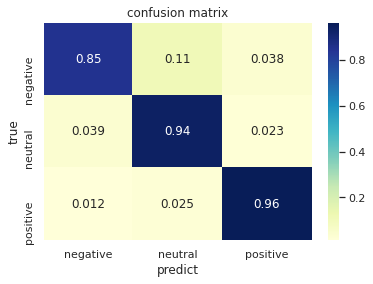

test_index:18865==>21560
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.04
epoch:0, step:100, loss:0.74
epoch:0, step:200, loss:0.40
epoch:0, step:300, loss:0.45
epoch:0, step:400, loss:0.30
epoch:0, step:500, loss:0.31
epoch:0, step:600, loss:0.18
*** 0.8951717495044987 0.9128304831284497 0.9139146567717996
0.9045432031381492, best: 0.9045432031381492
epoch:1, step:0, loss:0.17
epoch:1, step:100, loss:0.15
epoch:1, step:200, loss:0.18
epoch:1, step:300, loss:0.04
epoch:1, step:400, loss:0.06
epoch:1, step:500, loss:0.12
epoch:1, step:600, loss:0.15
*** 0.9223512216187487 0.9345312475299734 0.9343228200371058
0.9283370208279272, best: 0.9283370208279272
epoch:2, step:0, loss:0.04
epoch:2, step:100, loss:0.02
epoch:2, step:200, loss:0.15
epoch:2, step:300, loss:0.20
epoch:2, step:400, loss:0.04
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.26
*** 0.9190608234676771 0.9331389587054075 0.9324675324675324
0.9257641779676048, best: 0.9283370208279272
EarlySto

<Figure size 21600x21600 with 0 Axes>

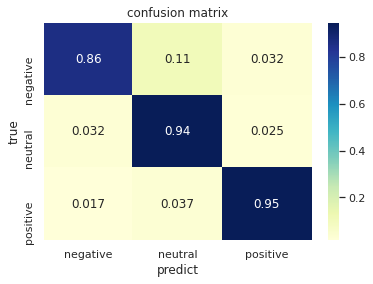

test_index:21560==>24255
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.88
epoch:0, step:200, loss:0.57
epoch:0, step:300, loss:0.23
epoch:0, step:400, loss:0.32
epoch:0, step:500, loss:0.31
epoch:0, step:600, loss:0.14
*** 0.8902825523455996 0.9084894416335128 0.9098330241187385
0.900057788232169, best: 0.900057788232169
epoch:1, step:0, loss:0.11
epoch:1, step:100, loss:0.20
epoch:1, step:200, loss:0.07
epoch:1, step:300, loss:0.08
epoch:1, step:400, loss:0.28
epoch:1, step:500, loss:0.20
epoch:1, step:600, loss:0.43
*** 0.9124796964510269 0.9264265382788832 0.9269016697588126
0.9196906831049197, best: 0.9196906831049197
epoch:2, step:0, loss:0.08
epoch:2, step:100, loss:0.07
epoch:2, step:200, loss:0.06
epoch:2, step:300, loss:0.03
epoch:2, step:400, loss:0.02
epoch:2, step:500, loss:0.17
epoch:2, step:600, loss:0.10
*** 0.9175866055782352 0.9323795201840237 0.9320964749536178
0.9248415402659265, best: 0.9248415402659265
EarlyStopp

<Figure size 21600x21600 with 0 Axes>

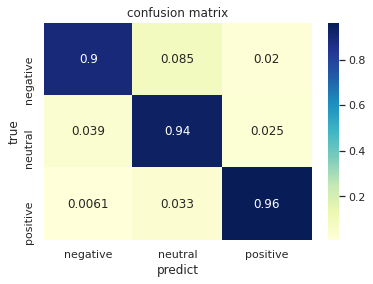

test_index:24255==>26950
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.11
epoch:0, step:100, loss:0.90
epoch:0, step:200, loss:0.56
epoch:0, step:300, loss:0.39
epoch:0, step:400, loss:0.67
epoch:0, step:500, loss:0.42
epoch:0, step:600, loss:0.20
*** 0.8944921834207848 0.9138603596726534 0.9142857142857143
0.9043889488532495, best: 0.9043889488532495
epoch:1, step:0, loss:0.16
epoch:1, step:100, loss:0.06
epoch:1, step:200, loss:0.05
epoch:1, step:300, loss:0.16
epoch:1, step:400, loss:0.19
epoch:1, step:500, loss:0.10
epoch:1, step:600, loss:0.04
*** 0.91143414503646 0.9289709097202252 0.9298701298701298
0.920652137453295, best: 0.920652137453295
epoch:2, step:0, loss:0.25
epoch:2, step:100, loss:0.07
epoch:2, step:200, loss:0.05
epoch:2, step:300, loss:0.31
epoch:2, step:400, loss:0.08
epoch:2, step:500, loss:0.36
epoch:2, step:600, loss:0.01
*** 0.9170731777644044 0.9342883519529727 0.935064935064935
0.9260690564146697, best: 0.9260690564146697
epoch:3, step

<Figure size 21600x21600 with 0 Axes>

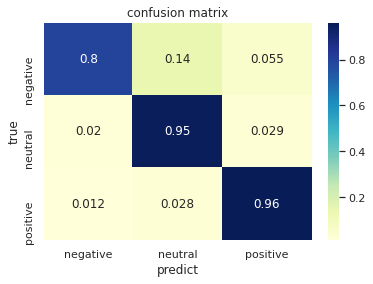

[0.9153824064745332, 0.9174561780164603, 0.9180612066813151, 0.9163145350788208, 0.912958192351648, 0.9240902625362342, 0.9173191736793315, 0.9173954508975098, 0.9272058978137551, 0.9132164874834268]
[0.9294346827241159, 0.9337185664400761, 0.9320316133042253, 0.9282384900038866, 0.9305912157150638, 0.937649422191272, 0.933925832460275, 0.9305733922159902, 0.938925680452906, 0.9301335238098248]
[0.9294990723562152, 0.9343228200371058, 0.9328385899814471, 0.9283858998144713, 0.9309833024118739, 0.9380333951762523, 0.9339517625231911, 0.9306122448979591, 0.9387755102040817, 0.9309833024118739]
max macro_f1:0.9272058978137551, max weight_f1:0.938925680452906,max acc:0.9387755102040817
min macro_f1:0.912958192351648, min weight_f1:0.9282384900038866,min acc:0.9283858998144713
mean macro_f1:0.9179399791013034, mean weight_f1:0.9325222419317637,mean acc:0.9328385899814473


In [8]:
shuffle_index = list(range(len(y)))
# random.Random(1337).shuffle(shuffle_index) 

f1_macro_list = []
f1_weighted_list = []
acc_list = []

import time
for fold in range(10):
    
    
    train_data_loader,val_data_loader,test_data_loader = get_data_loader(shuffle_index,fold)
    
    early_stopping = EarlyStopping( delta=1e-4, patience=3)
    
    #构造模型 
    net = Classifier(embed_size = EMBED_SIZE,labels=LABELS,max_length = MAX_LENGTH,pixel = PIXEL,glove_weight=glove_weight)
    net.to(torch.device(DEVICE))


    optimizer = torch.optim.Adam(params = net.parameters(),
                                 lr = 1e-4)

    loss_func = nn.CrossEntropyLoss()

    begin = time.time()
    max_acc = 0
    # training and testing
    for epoch in range(NB_EPOCH):
        net.train()
        for step, (b_texts,b_image_features, b_y) in enumerate(train_data_loader):        # gives batch data
            b_texts = b_texts.to(torch.device(DEVICE))
            b_image_features = b_image_features.to(torch.device(DEVICE))
            b_y = b_y.to(torch.device(DEVICE))


            out = net(b_texts,b_image_features)                               # rnn output
            loss = loss_func(out, b_y) 
            if step %100 ==0:
                print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
            optimizer.zero_grad()                           # clear gradients for this training step
            loss.backward()                                 # backpropagation, compute gradients
            optimizer.step()                                # apply gradients

        net.eval()
        #每训练一轮，使用验证集验证
        f1_macro,f1_weighted,acc,test_Y,pred_Y,val_loss = model_test(val_data_loader,net)

        print('***',f1_macro,f1_weighted,acc)

        acc = (f1_macro+acc)/2
        if acc >max_acc:
            max_acc = acc
            torch.save(net, 'best_twitter.pkl')
        print('{acc}, best: {max_acc}'.format(acc = acc,max_acc = max_acc))
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    print('run time:',time.time()-begin)
    
    net = torch.load('best_twitter.pkl')
    net.eval()

    f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean = model_test(test_data_loader, net,report = True)

    print('----***----',f1_macro,f1_weighted,acc)
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    acc_list.append(acc)
    draw_cofusion_matrix(test_Y,pred_Y)

print(f1_macro_list)
print(f1_weighted_list)
print(acc_list)
print('max macro_f1:{macro_f1}, max weight_f1:{weight_f1},max acc:{acc}'.format(
    macro_f1 = max(f1_macro_list),weight_f1 = max(f1_weighted_list),acc = max(acc_list)))
print('min macro_f1:{macro_f1}, min weight_f1:{weight_f1},min acc:{acc}'.format(
    macro_f1 = min(f1_macro_list),weight_f1 = min(f1_weighted_list),acc = min(acc_list)))
print('mean macro_f1:{macro_f1}, mean weight_f1:{weight_f1},mean acc:{acc}'.format(
    macro_f1 = np.mean(f1_macro_list),weight_f1 = np.mean(f1_weighted_list),acc = np.mean(acc_list)))

